In [1]:
import zipfile

# Path to the zip file
zip_file_path = ('archive8.zip')

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the current working directory
    zip_ref.extractall()


# Imorting the needed Libraries

In [2]:
import numpy as np
import os, shutil
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
import numpy as np
import pandas as pd 
import cv2
import random
%matplotlib inline
plt.style.use('ggplot')


In [3]:
import os
import cv2
import numpy as np

img_size = 128

def get_data(data_dir, labels):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if img == ".DS_Store":
                continue  # Skip .DS_Store files
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Check if the image was read successfully
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))
                    data.append([resized_arr, class_num])
                else:
                    print(f"Error: Unable to read image '{os.path.join(path, img)}'")
            except Exception as e:
                print(e)
    if data:  # Check if data is not empty
        # Separate the features (image arrays) and labels
        features, labels = zip(*data)
        # Convert features and labels to NumPy arrays
        features = np.array(features)
        labels = np.array(labels)
        # Reshape features array to ensure consistency
        features = features.reshape(-1, img_size, img_size, 1)
        return features, labels
    else:
        print("Error: No data found.")
        return None, None

# Define labels
labels = ['PNEUMONIA', 'NORMAL']

# Usage
train_features, train_labels = get_data("chest_xray/chest_xray/train", labels)
test_features, test_labels = get_data("chest_xray/chest_xray/test", labels)
val_features, val_labels = get_data("chest_xray/chest_xray/val", labels)


In [4]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

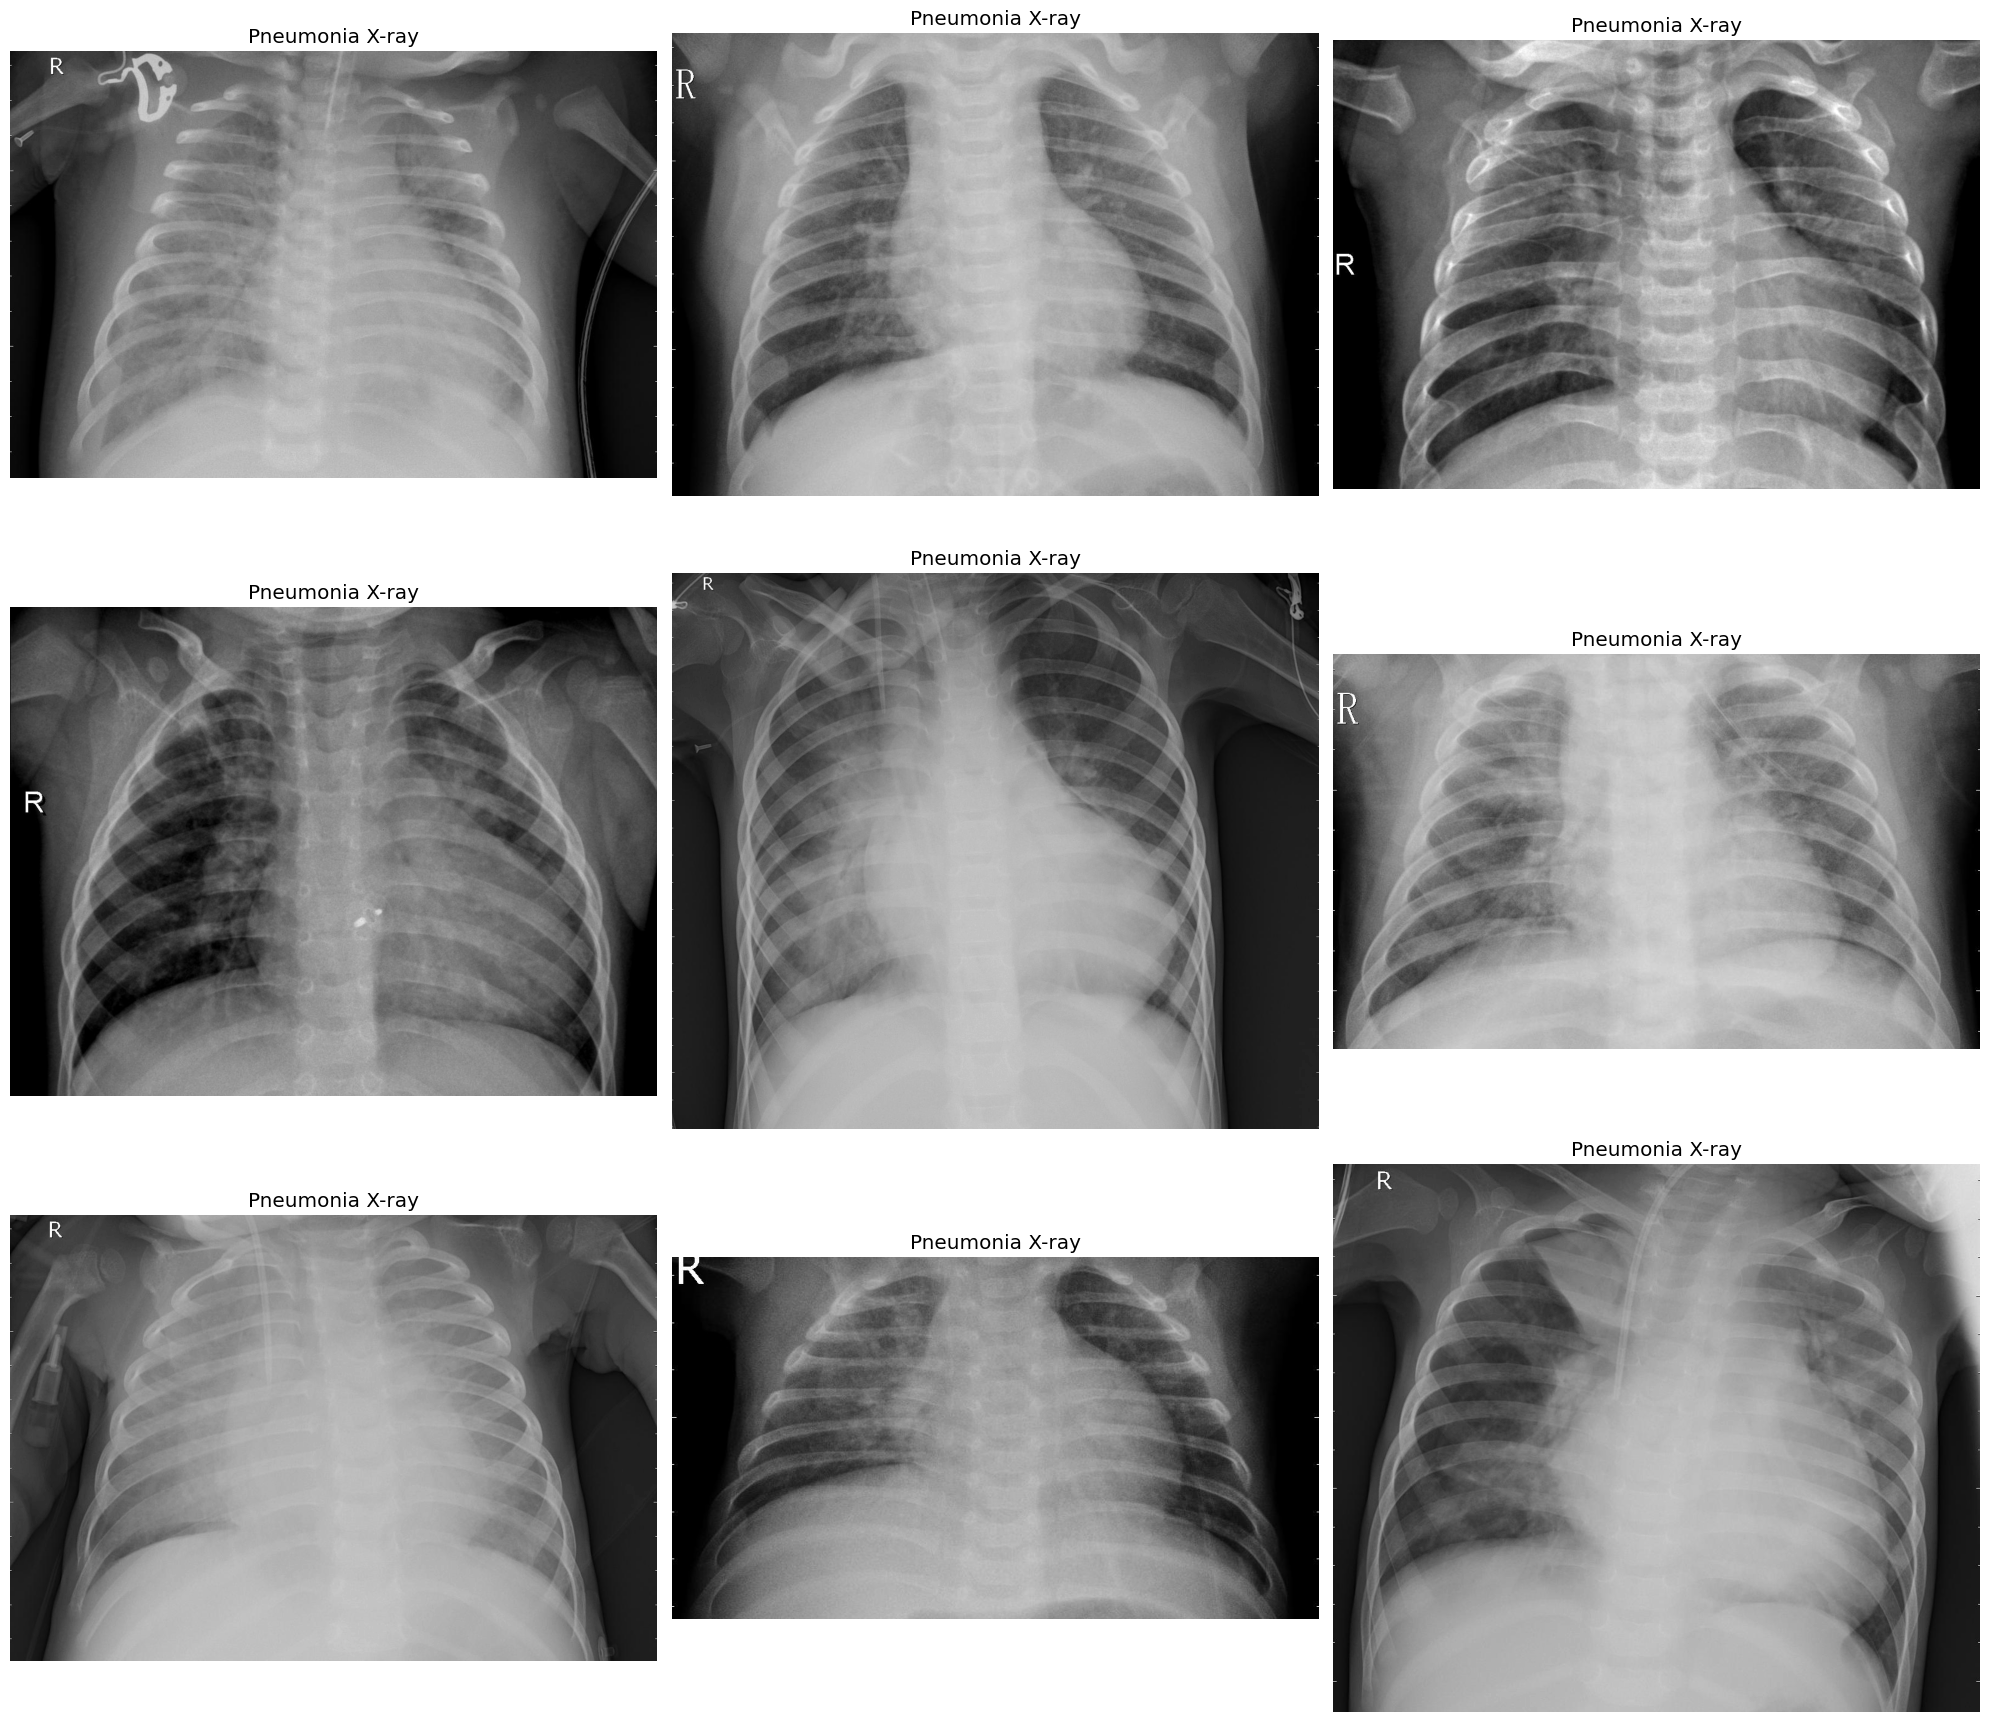

In [6]:
plt.figure(figsize=(20, 18))

for i in range(9):
    img_path = os.path.join(pneumonia_dir, pneumonia[i])
    img = plt.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()
plt.show()

In [8]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

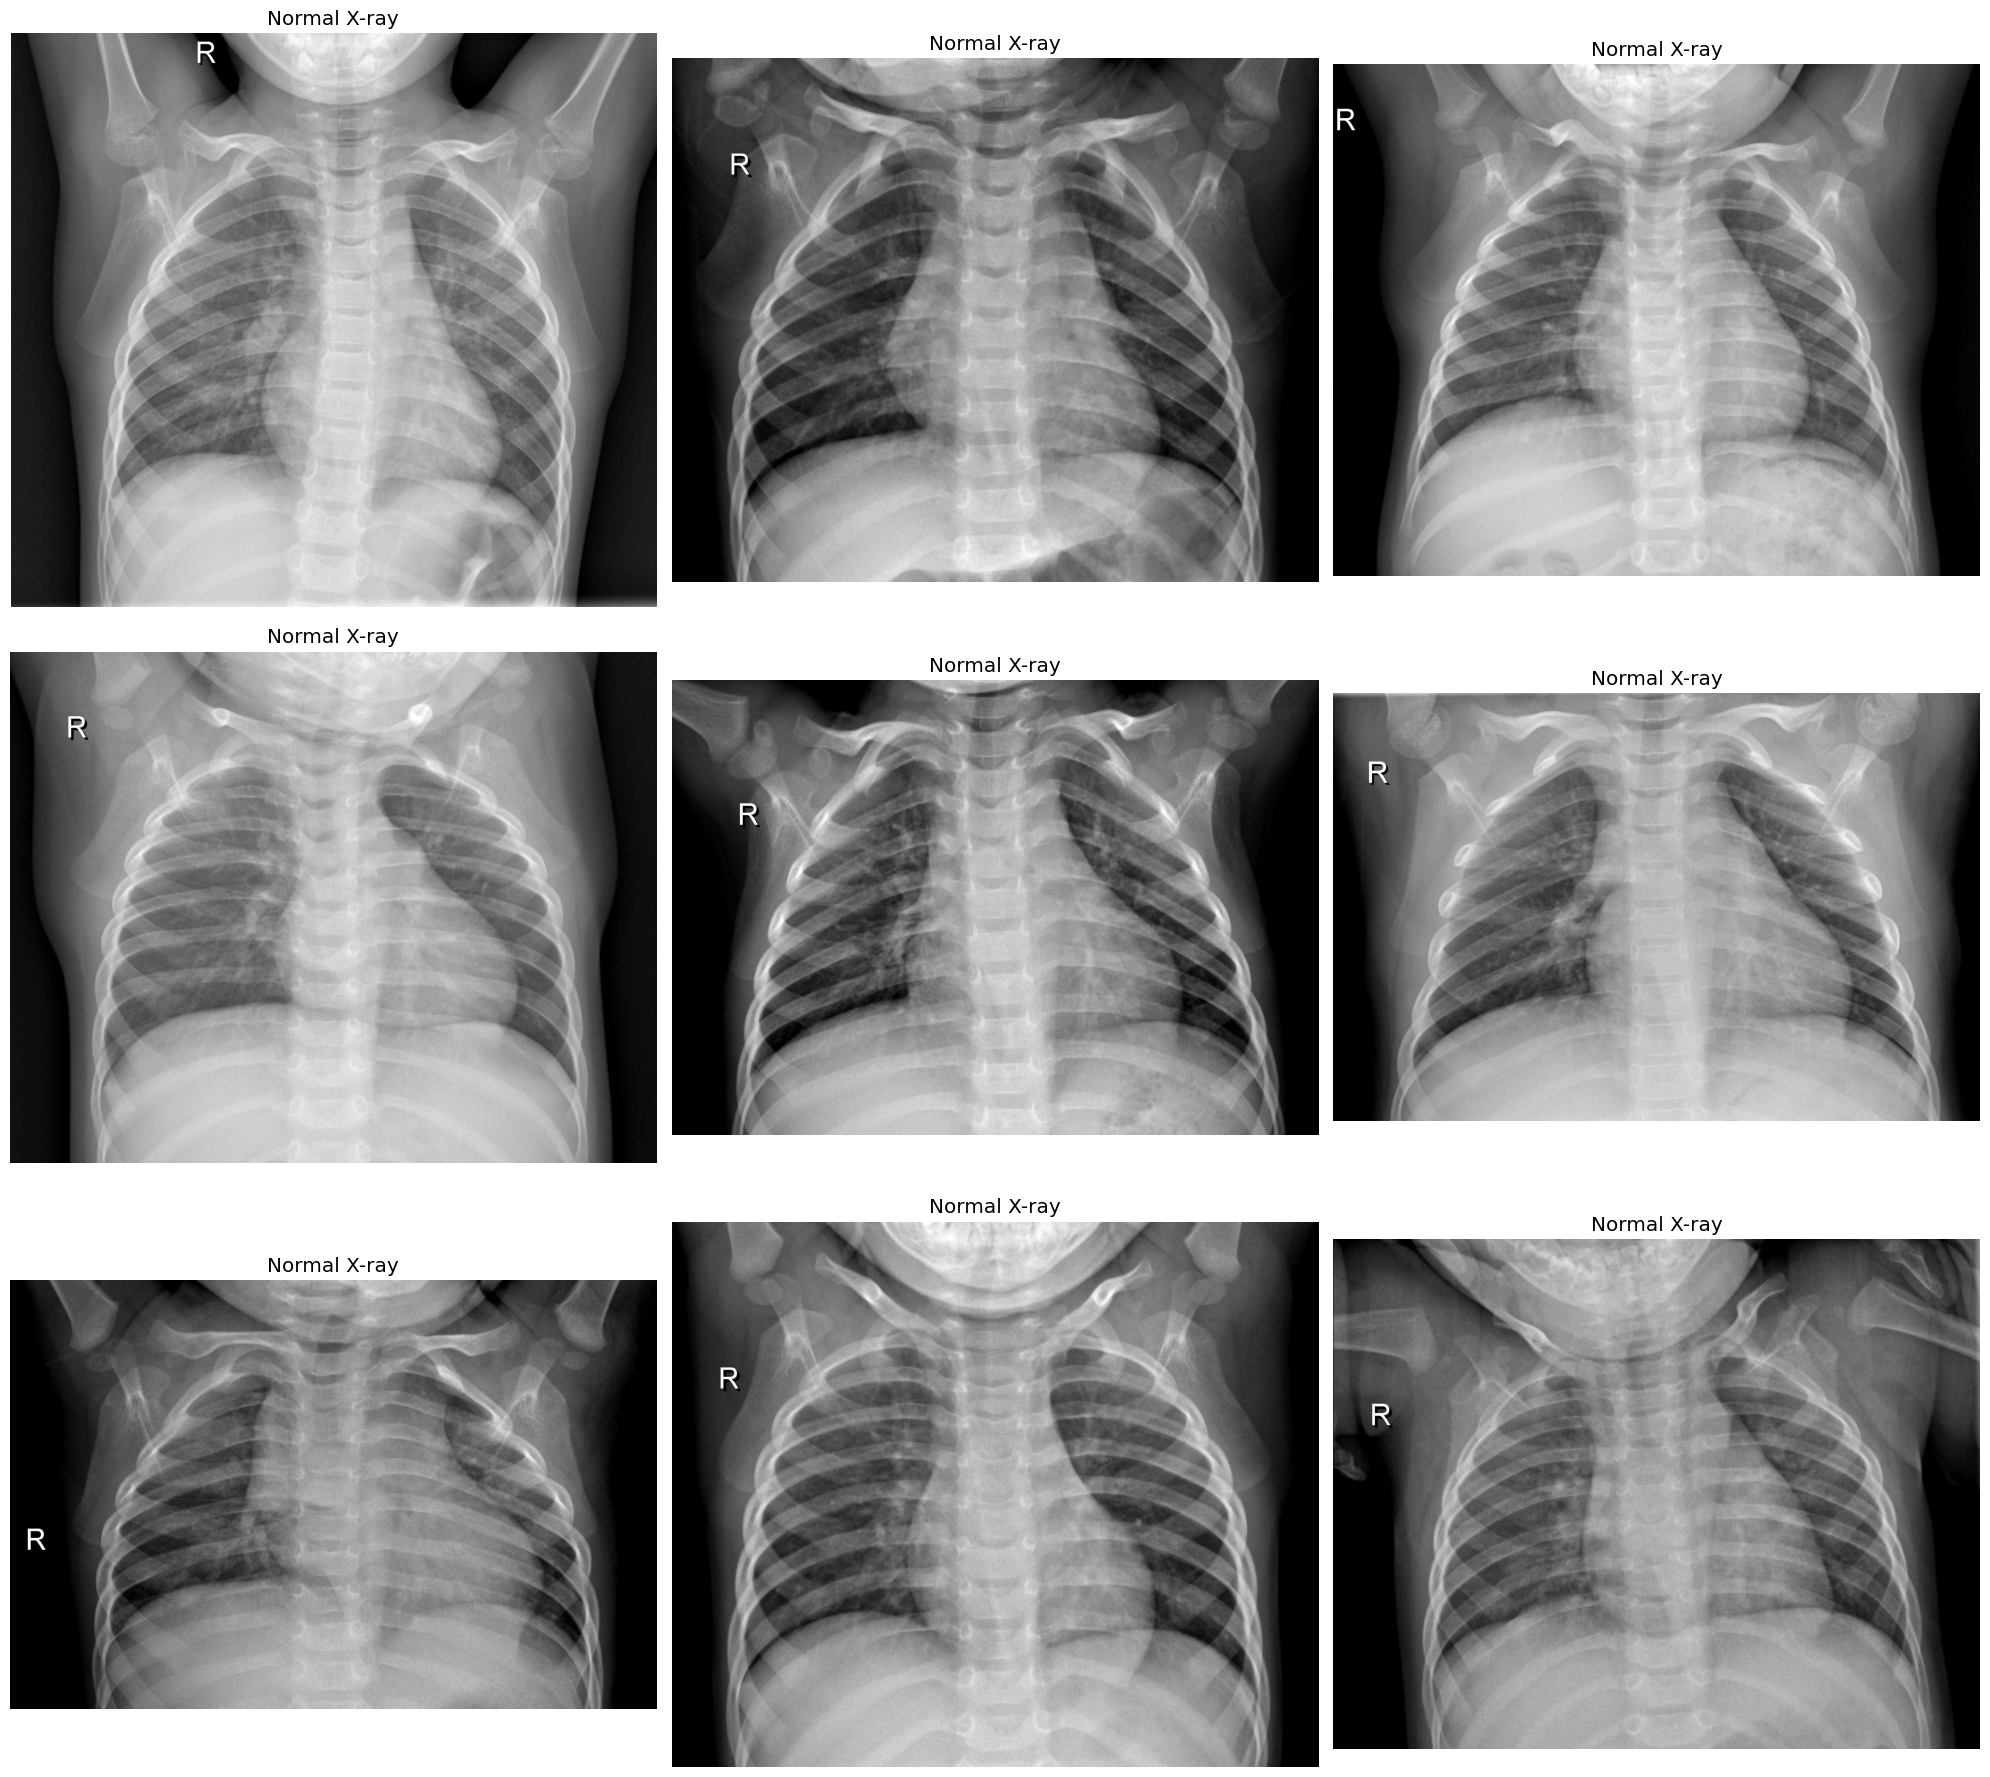

In [13]:
plt.figure(figsize=(20, 18))

for i in range(9):
    img_path = os.path.join(normal_dir, normal[i])
    img = plt.imread(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
    
plt.tight_layout()
plt.show()

 ### Visualizing to know the number of photos in each folder 

C:\Users\ADDIS\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


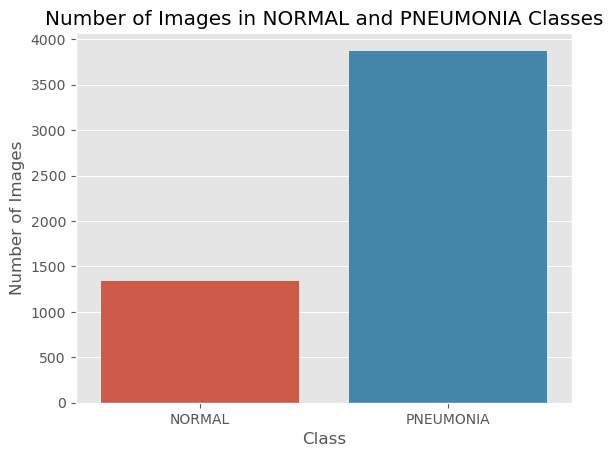

In [21]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the directories for NORMAL and PNEUMONIA images
normal_dir = "chest_xray/train/NORMAL"
pneumonia_dir = "chest_xray/train/PNEUMONIA"

# Count the number of images in each directory
num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

# Create a bar plot
sns.barplot(x=["NORMAL", "PNEUMONIA"], y=[num_normal, num_pneumonia])
plt.title("Number of Images in NORMAL and PNEUMONIA Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


### Showing the total  number of Images contained in the data

In [20]:
normal_dir = "chest_xray/train/NORMAL"
pneumonia_dir = "chest_xray/train/PNEUMONIA"

# Count the number of images in each directory
num_normal = len(os.listdir(normal_dir))
num_pneumonia = len(os.listdir(pneumonia_dir))

# Print the number of images for each class
print("Number of NORMAL images:", num_normal)
print("Number of PNEUMONIA images:", num_pneumonia)

Number of NORMAL images: 1341
Number of PNEUMONIA images: 3875


### Data Augmentation  and Resizing (Importing Tensorflow & neccessary Modules)

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [28]:
train_datagen = ImageDataGenerator(rescale =1. /255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2, 
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1. /255)
test_datagen = ImageDataGenerator(rescale = 1. /255)

In [31]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size=32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed =42,
                                 color_mode ='rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode ='categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [32]:
class_labels = train_generator.class_indices

In [33]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [36]:
class_name = {value:key for (key, value) in class_labels.items()}

In [37]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

# VGG19 Architecture 
 Used for "Very Deep Convolutional Networks for Large-Scale Image Recognition."

VGG19 is particularly popular for image classification tasks 

In [43]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the pre-trained VGG19 model
base_model = VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define the rest of your model architecture
x = base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

# Define the final model
model_01 = Model(base_model.inputs, output)
model_01.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# Define file path for saving the model
filepath = "model.h5"

# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp = ModelCheckpoint(filepath, monitor="val_accuracy", save_best_only=True, save_weights_only=False, mode="max")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# Define optimizer
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)

# Compile the model
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


In [60]:
history_01 = model_01.fit(train_generator,
            steps_per_epoch=50,
            epochs=1,
            callbacks=[es,cp,lrr],
            validation_data=valid_generator)



50/50 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7394

C:\Users\ADDIS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


50/50 [==============================] - 116s 2s/step - loss: 0.5558 - accuracy: 0.7394 - val_loss: 0.6668 - val_accuracy: 0.5000 - lr: 1.0000e-04


In [61]:
if not os.path.isdir('model_weight/'):
    os.mkdir("model_weights/" )
model_01.save(filepath="model_weights/vgg19_model_01.hs", overwrite=True)

INFO:tensorflow:Assets written to: model_weights/vgg19_model_01.hs\assets


INFO:tensorflow:Assets written to: model_weights/vgg19_model_01.hs\assets


In [62]:
test_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode ='categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 16 images belonging to 2 classes.


In [66]:
model_01.load_weights("model_weights/vgg19_model_01.hs")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 [==============================] - 1s 1s/step - loss: 0.6668 - accuracy: 0.5000


In [69]:
print(f"validation loss): {vgg_val_eval_01[0]}")
print(f"validation Accuracy:{vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuracy:{vgg_test_eval_01[1]}")  

validation loss): 0.6667637825012207
validation Accuracy:0.5
Test Loss: 0.6667637825012207
Test Accuracy:0.5


In [75]:
base_model = VGG19(include_top=False, input_shape=(128, 128, 3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

# Define the final model
model_02 = Model(base_model.inputs, output)

# Load weights
model_02.load_weights("model_weights/vgg19_model_01.hs")

set_trainable = False
for layer in base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print(model_02.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [71]:
base_model_layer_names

['input_4',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [78]:
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])


In [80]:
sgd = SGD(learning_rate=0.0001, momentum=0.9)

# Compile the model
model_02.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_02 = model_02.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=1,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator)

10/10 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7531

C:\Users\ADDIS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 37s 3s/step - loss: 0.5316 - accuracy: 0.7531 - val_loss: 0.6098 - val_accuracy: 0.5625 - lr: 1.0000e-04


In [84]:
import os

# Check if the directory exists
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")

# Save the model
model_01.save(filepath="model_weights/vgg19_model_02.h5", overwrite=True)


In [85]:

model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"validation loss): {vgg_val_eval_01[0]}")
print(f"validation Accuracy:{vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuracy:{vgg_test_eval_01[1]}")  

1/1 [==============================] - 2s 2s/step - loss: 0.6668 - accuracy: 0.5000
validation loss): 0.6667637825012207
validation Accuracy:0.5
Test Loss: 0.6667637825012207
Test Accuracy:0.5


In [86]:
##unfreezing and fine tuning

In [87]:
base_model = VGG19(include_top=False, input_shape=(128, 128, 3))


x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

# Define the final model
model_03 = Model(base_model.inputs, output)

# Load weights
model_03.load_weights("model_weights/vgg19_model_01.hs")



print(model_03.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [89]:
sgd = SGD(learning_rate=0.0001, momentum=0.9)

# Compile the model
model_03.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_03 = model_03.fit(train_generator,
            steps_per_epoch=100,
            epochs=1,
            callbacks=[es,cp,lrr],
            validation_data=valid_generator)

 92/100 [==========================>...] - ETA: 31:18 - loss: 0.4118 - accuracy: 0.7979

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")

# Save the model
model_01.save(filepath="model_weights/vgg_19_model_02.h5", overwrite=True)
